In [1]:
from os import listdir
from numpy import asarray, load
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
# load all images in a directory into memory
def load_images(path, size=(256,512)):
	src_list, tar_list = list(), list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# split into satellite and map
		sat_img, map_img = pixels[:, :256], pixels[:, 256:]
		src_list.append(sat_img)
		tar_list.append(map_img)
	return [asarray(src_list), asarray(tar_list)]

In [4]:
path = "./maps/train/"

In [5]:
x=load_images(path)

In [6]:
src_images = x[0]
tar_images = x[1]

In [7]:
src_images.shape

(1096, 256, 256, 3)

In [8]:
import cv2

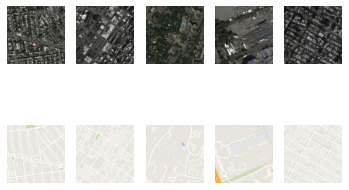

In [9]:
n_samples = 5
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [10]:
# pix2_pix model

In [11]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model

In [12]:
def define_discriminator(image_shape):
    
	# weight initialization
	init = RandomNormal(stddev=0.02) #As described in the original paper
    
	# source image input
	in_src_image = Input(shape=image_shape)  #Image we want to convert to another image
	# target image input
	in_target_image = Input(shape=image_shape)  #Image we want to generate after training. 
    
	# concatenate images, channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
    
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2 
    # Not in the original paper. Comment this block if you want.
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
    #The model is trained with a batch size of one image and Adam opt. 
    #with a small learning rate and 0.5 beta. 
    #The loss for the discriminator is weighted by 50% for each model update.
    
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [13]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

In [14]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

In [15]:
# define the standalone generator model - U-net
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD512-CD512-C512-C256-C128-C64
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified 
	out_image = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1
	# define model
	model = Model(in_image, out_image)
	return model

In [16]:
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False       #Descriminator layers set to untrainable in the combined GAN but 
                                                #standalone descriminator will be trainable.
            
	# define the source image
	in_src = Input(shape=image_shape)
	# suppy the image as input to the generator 
	gen_out = g_model(in_src)
	# supply the input image and generated image as inputs to the discriminator
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and disc. output as outputs
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
    
    #Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
    #Authors suggested weighting BCE vs L1 as 1:100.
	model.compile(loss=['binary_crossentropy', 'mae'], 
               optimizer=opt, loss_weights=[1,100])
	return model

In [17]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [18]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [19]:
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [20]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

### back to traing and fitting and testing

In [21]:
image_shape = src_images.shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

In [22]:
d_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256, 256, 6)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 6208        concatenate[0][0]     

In [23]:
data = [src_images, tar_images]

def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)

from datetime import datetime 
start1 = datetime.now() 

In [24]:
train(d_model, g_model, gan_model, dataset, n_epochs=10, n_batch=1) 
#Reports parameters for each batch (total 1096) for each epoch.
#For 10 epochs we should see 10960

stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

>1, d1[0.380] d2[0.737] g[92.629]
>2, d1[0.301] d2[0.586] g[88.392]
>3, d1[0.244] d2[0.592] g[72.290]
>4, d1[0.371] d2[0.650] g[69.736]
>5, d1[0.431] d2[0.401] g[80.289]
>6, d1[0.354] d2[0.368] g[78.797]
>7, d1[0.341] d2[0.370] g[77.850]
>8, d1[0.274] d2[0.325] g[71.420]
>9, d1[0.276] d2[0.321] g[72.107]
>10, d1[0.235] d2[0.318] g[61.684]
>11, d1[0.537] d2[0.387] g[57.902]
>12, d1[0.125] d2[0.253] g[65.777]
>13, d1[0.216] d2[0.247] g[59.886]
>14, d1[0.106] d2[0.158] g[60.739]
>15, d1[0.085] d2[0.150] g[57.533]
>16, d1[0.082] d2[0.099] g[53.064]
>17, d1[0.109] d2[0.325] g[39.373]
>18, d1[0.315] d2[0.131] g[47.953]
>19, d1[0.042] d2[0.130] g[45.880]
>20, d1[0.056] d2[0.091] g[43.471]
>21, d1[1.585] d2[1.910] g[18.415]
>22, d1[0.035] d2[0.334] g[37.777]
>23, d1[0.522] d2[0.199] g[34.867]
>24, d1[0.320] d2[0.262] g[31.779]
>25, d1[0.268] d2[0.329] g[31.079]
>26, d1[0.166] d2[0.167] g[26.566]
>27, d1[1.228] d2[1.010] g[21.226]
>28, d1[0.204] d2[0.193] g[25.451]
>29, d1[0.405] d2[0.340] g[21

>234, d1[0.319] d2[0.260] g[8.675]
>235, d1[0.010] d2[0.126] g[10.716]
>236, d1[0.294] d2[0.210] g[8.481]
>237, d1[0.008] d2[0.163] g[10.020]
>238, d1[0.008] d2[0.119] g[24.596]
>239, d1[0.021] d2[0.130] g[10.985]
>240, d1[0.044] d2[0.044] g[21.343]
>241, d1[0.445] d2[0.399] g[9.638]
>242, d1[0.013] d2[0.063] g[15.946]
>243, d1[0.012] d2[0.048] g[13.298]
>244, d1[0.333] d2[0.064] g[10.914]
>245, d1[0.027] d2[0.180] g[10.521]
>246, d1[0.011] d2[0.356] g[23.516]
>247, d1[0.032] d2[0.098] g[13.358]
>248, d1[0.103] d2[0.114] g[22.541]
>249, d1[1.581] d2[0.062] g[22.661]
>250, d1[1.141] d2[0.128] g[22.778]
>251, d1[0.032] d2[0.363] g[22.725]
>252, d1[0.669] d2[0.149] g[13.281]
>253, d1[0.179] d2[0.250] g[12.937]
>254, d1[0.369] d2[0.212] g[20.903]
>255, d1[0.059] d2[0.212] g[18.741]
>256, d1[0.348] d2[0.193] g[17.920]
>257, d1[0.083] d2[0.397] g[13.183]
>258, d1[0.508] d2[0.183] g[11.051]
>259, d1[0.114] d2[0.149] g[19.198]
>260, d1[0.303] d2[0.360] g[10.827]
>261, d1[0.180] d2[0.240] g[11.

>463, d1[0.046] d2[0.061] g[12.417]
>464, d1[0.057] d2[0.075] g[12.263]
>465, d1[0.030] d2[0.088] g[11.790]
>466, d1[0.146] d2[0.192] g[22.129]
>467, d1[0.132] d2[0.110] g[11.514]
>468, d1[0.274] d2[0.267] g[9.416]
>469, d1[0.229] d2[0.237] g[10.464]
>470, d1[0.006] d2[0.264] g[22.589]
>471, d1[0.339] d2[0.358] g[17.287]
>472, d1[1.152] d2[0.125] g[13.223]
>473, d1[0.529] d2[0.385] g[10.739]
>474, d1[0.125] d2[0.685] g[18.566]
>475, d1[1.006] d2[0.112] g[10.222]
>476, d1[0.038] d2[0.143] g[19.803]
>477, d1[0.615] d2[0.318] g[11.305]
>478, d1[0.415] d2[0.257] g[10.177]
>479, d1[0.179] d2[0.273] g[8.851]
>480, d1[0.475] d2[0.612] g[18.185]
>481, d1[0.101] d2[0.209] g[13.624]
>482, d1[0.448] d2[0.223] g[12.989]
>483, d1[0.216] d2[0.286] g[9.784]
>484, d1[0.138] d2[0.134] g[9.987]
>485, d1[0.011] d2[0.146] g[17.156]
>486, d1[0.354] d2[0.135] g[8.646]
>487, d1[0.039] d2[0.216] g[10.527]
>488, d1[0.122] d2[0.169] g[15.574]
>489, d1[0.316] d2[0.577] g[14.189]
>490, d1[0.093] d2[0.246] g[9.218

>692, d1[0.006] d2[0.093] g[12.837]
>693, d1[0.801] d2[0.790] g[15.126]
>694, d1[0.003] d2[0.035] g[16.076]
>695, d1[0.798] d2[0.095] g[10.408]
>696, d1[0.161] d2[0.285] g[10.123]
>697, d1[0.074] d2[0.222] g[9.427]
>698, d1[0.032] d2[0.138] g[25.436]
>699, d1[0.290] d2[0.050] g[17.289]
>700, d1[0.195] d2[0.219] g[9.776]
>701, d1[0.329] d2[0.224] g[9.919]
>702, d1[0.002] d2[0.243] g[12.307]
>703, d1[0.203] d2[0.147] g[15.840]
>704, d1[0.613] d2[0.097] g[10.451]
>705, d1[0.124] d2[0.222] g[9.705]
>706, d1[0.001] d2[0.144] g[14.152]
>707, d1[0.047] d2[0.081] g[12.516]
>708, d1[0.162] d2[0.554] g[14.403]
>709, d1[0.230] d2[0.128] g[9.115]
>710, d1[0.482] d2[0.120] g[16.741]
>711, d1[0.070] d2[0.218] g[10.947]
>712, d1[0.004] d2[0.145] g[14.304]
>713, d1[0.081] d2[0.570] g[17.545]
>714, d1[0.649] d2[0.072] g[9.535]
>715, d1[0.314] d2[0.051] g[18.542]
>716, d1[0.006] d2[1.244] g[12.204]
>717, d1[0.538] d2[0.295] g[10.216]
>718, d1[0.559] d2[0.497] g[9.846]
>719, d1[0.026] d2[0.043] g[24.224]

>921, d1[0.656] d2[0.537] g[11.561]
>922, d1[0.401] d2[0.161] g[10.074]
>923, d1[0.048] d2[0.727] g[13.099]
>924, d1[0.145] d2[0.079] g[14.018]
>925, d1[0.237] d2[0.299] g[8.882]
>926, d1[0.758] d2[0.262] g[10.327]
>927, d1[0.051] d2[0.160] g[10.534]
>928, d1[0.050] d2[0.109] g[17.388]
>929, d1[0.245] d2[0.130] g[16.274]
>930, d1[0.167] d2[0.460] g[11.479]
>931, d1[0.005] d2[0.040] g[18.184]
>932, d1[0.118] d2[0.050] g[14.216]
>933, d1[0.842] d2[0.185] g[10.787]
>934, d1[0.189] d2[1.836] g[10.018]
>935, d1[0.189] d2[0.143] g[9.453]
>936, d1[0.308] d2[0.128] g[10.661]
>937, d1[0.456] d2[0.196] g[13.202]
>938, d1[0.010] d2[0.128] g[16.374]
>939, d1[0.077] d2[0.106] g[18.818]
>940, d1[0.006] d2[0.178] g[17.179]
>941, d1[0.155] d2[0.306] g[10.221]
>942, d1[0.114] d2[0.101] g[10.314]
>943, d1[0.062] d2[0.066] g[13.174]
>944, d1[0.499] d2[0.200] g[11.469]
>945, d1[0.904] d2[0.185] g[18.523]
>946, d1[0.397] d2[0.443] g[9.725]
>947, d1[0.018] d2[0.261] g[9.850]
>948, d1[1.062] d2[0.131] g[14.7

>1147, d1[0.035] d2[0.059] g[9.995]
>1148, d1[0.001] d2[0.076] g[11.223]
>1149, d1[0.001] d2[0.040] g[14.715]
>1150, d1[0.174] d2[0.194] g[9.944]
>1151, d1[0.153] d2[0.053] g[12.025]
>1152, d1[0.010] d2[0.190] g[11.168]
>1153, d1[0.003] d2[0.068] g[17.062]
>1154, d1[0.005] d2[0.119] g[11.843]
>1155, d1[0.001] d2[0.063] g[15.533]
>1156, d1[0.899] d2[0.377] g[13.072]
>1157, d1[0.002] d2[0.087] g[32.129]
>1158, d1[0.526] d2[0.593] g[11.524]
>1159, d1[0.042] d2[0.071] g[11.917]
>1160, d1[0.997] d2[0.200] g[9.490]
>1161, d1[0.145] d2[0.749] g[9.881]
>1162, d1[0.423] d2[0.134] g[10.142]
>1163, d1[0.004] d2[0.034] g[18.257]
>1164, d1[0.294] d2[0.140] g[10.879]
>1165, d1[0.146] d2[0.741] g[9.608]
>1166, d1[0.104] d2[0.189] g[11.563]
>1167, d1[0.939] d2[0.063] g[9.383]
>1168, d1[0.079] d2[0.125] g[9.848]
>1169, d1[0.066] d2[0.142] g[11.176]
>1170, d1[0.145] d2[0.291] g[9.466]
>1171, d1[0.003] d2[0.074] g[12.601]
>1172, d1[0.377] d2[0.165] g[9.026]
>1173, d1[0.153] d2[0.272] g[8.817]
>1174, d1[0

>1371, d1[0.479] d2[0.550] g[10.064]
>1372, d1[0.003] d2[0.068] g[14.396]
>1373, d1[0.019] d2[0.033] g[11.797]
>1374, d1[0.002] d2[0.029] g[22.486]
>1375, d1[0.007] d2[0.034] g[18.883]
>1376, d1[0.756] d2[0.077] g[16.152]
>1377, d1[0.003] d2[0.202] g[16.216]
>1378, d1[0.484] d2[0.640] g[9.277]
>1379, d1[0.290] d2[0.163] g[9.365]
>1380, d1[0.047] d2[0.272] g[16.507]
>1381, d1[0.477] d2[0.129] g[9.588]
>1382, d1[0.113] d2[0.257] g[11.973]
>1383, d1[0.001] d2[0.147] g[14.455]
>1384, d1[0.742] d2[0.423] g[9.771]
>1385, d1[0.001] d2[0.054] g[14.456]
>1386, d1[0.028] d2[0.097] g[13.148]
>1387, d1[0.601] d2[0.162] g[9.614]
>1388, d1[0.499] d2[0.278] g[10.544]
>1389, d1[0.034] d2[0.492] g[10.338]
>1390, d1[0.006] d2[0.052] g[12.502]
>1391, d1[0.861] d2[0.088] g[8.478]
>1392, d1[0.001] d2[0.139] g[12.668]
>1393, d1[0.006] d2[0.063] g[11.469]
>1394, d1[0.222] d2[0.910] g[9.364]
>1395, d1[0.028] d2[0.116] g[13.631]
>1396, d1[0.339] d2[0.082] g[9.879]
>1397, d1[0.200] d2[0.178] g[9.909]
>1398, d1[

>1595, d1[0.374] d2[0.084] g[13.603]
>1596, d1[0.079] d2[0.364] g[12.526]
>1597, d1[0.030] d2[0.119] g[9.286]
>1598, d1[0.081] d2[0.130] g[10.883]
>1599, d1[0.004] d2[0.062] g[16.869]
>1600, d1[0.115] d2[0.167] g[9.048]
>1601, d1[0.017] d2[0.067] g[15.015]
>1602, d1[0.001] d2[0.060] g[16.486]
>1603, d1[0.455] d2[0.376] g[10.745]
>1604, d1[0.001] d2[0.041] g[14.918]
>1605, d1[0.410] d2[0.106] g[12.811]
>1606, d1[0.077] d2[0.163] g[12.159]
>1607, d1[0.008] d2[0.214] g[24.751]
>1608, d1[0.214] d2[0.084] g[8.933]
>1609, d1[0.091] d2[0.134] g[10.968]
>1610, d1[0.014] d2[0.075] g[20.425]
>1611, d1[0.145] d2[0.441] g[12.545]
>1612, d1[0.006] d2[0.049] g[15.617]
>1613, d1[0.555] d2[0.195] g[12.137]
>1614, d1[0.002] d2[0.136] g[12.202]
>1615, d1[0.541] d2[0.520] g[8.328]
>1616, d1[0.002] d2[0.042] g[16.088]
>1617, d1[1.221] d2[0.102] g[11.024]
>1618, d1[0.424] d2[0.248] g[8.688]
>1619, d1[0.008] d2[0.173] g[11.117]
>1620, d1[0.006] d2[0.080] g[14.510]
>1621, d1[0.006] d2[0.068] g[18.308]
>1622,

>1819, d1[0.006] d2[0.059] g[11.794]
>1820, d1[0.079] d2[0.058] g[10.715]
>1821, d1[0.001] d2[0.067] g[15.598]
>1822, d1[0.168] d2[0.114] g[10.233]
>1823, d1[0.270] d2[0.147] g[21.358]
>1824, d1[0.001] d2[0.222] g[12.119]
>1825, d1[0.029] d2[0.106] g[14.751]
>1826, d1[0.264] d2[0.255] g[10.627]
>1827, d1[0.507] d2[0.423] g[8.254]
>1828, d1[0.001] d2[0.054] g[21.027]
>1829, d1[0.198] d2[0.143] g[10.194]
>1830, d1[0.001] d2[0.060] g[13.315]
>1831, d1[0.005] d2[0.085] g[9.873]
>1832, d1[0.105] d2[0.267] g[15.336]
>1833, d1[0.012] d2[0.201] g[9.598]
>1834, d1[0.137] d2[0.051] g[10.072]
>1835, d1[0.846] d2[0.313] g[7.911]
>1836, d1[0.001] d2[0.098] g[18.038]
>1837, d1[0.001] d2[0.037] g[17.507]
>1838, d1[0.859] d2[0.164] g[9.517]
>1839, d1[0.001] d2[0.166] g[10.105]
>1840, d1[0.361] d2[0.883] g[8.347]
>1841, d1[0.011] d2[0.066] g[11.294]
>1842, d1[0.018] d2[0.032] g[10.599]
>1843, d1[0.001] d2[0.029] g[18.651]
>1844, d1[1.322] d2[0.053] g[8.261]
>1845, d1[0.001] d2[0.085] g[21.425]
>1846, d

>2043, d1[0.192] d2[0.258] g[9.657]
>2044, d1[0.001] d2[0.092] g[13.276]
>2045, d1[0.016] d2[0.102] g[12.127]
>2046, d1[0.003] d2[0.068] g[10.859]
>2047, d1[0.007] d2[0.061] g[11.217]
>2048, d1[0.058] d2[0.057] g[9.146]
>2049, d1[0.002] d2[0.048] g[18.454]
>2050, d1[0.002] d2[0.098] g[11.973]
>2051, d1[0.416] d2[0.277] g[8.969]
>2052, d1[0.385] d2[0.251] g[8.942]
>2053, d1[0.007] d2[0.065] g[14.999]
>2054, d1[0.194] d2[0.365] g[9.554]
>2055, d1[0.275] d2[0.121] g[9.891]
>2056, d1[0.068] d2[0.361] g[9.907]
>2057, d1[0.721] d2[0.086] g[11.005]
>2058, d1[0.225] d2[0.294] g[7.988]
>2059, d1[0.022] d2[0.217] g[12.823]
>2060, d1[0.004] d2[0.051] g[12.165]
>2061, d1[0.007] d2[0.045] g[9.832]
>2062, d1[0.004] d2[0.052] g[19.558]
>2063, d1[0.176] d2[0.043] g[9.610]
>2064, d1[0.002] d2[0.057] g[15.762]
>2065, d1[0.001] d2[0.069] g[16.326]
>2066, d1[0.150] d2[0.128] g[9.366]
>2067, d1[0.012] d2[0.056] g[12.980]
>2068, d1[0.001] d2[0.142] g[13.919]
>2069, d1[0.002] d2[0.078] g[15.231]
>2070, d1[0.

>2267, d1[0.012] d2[0.037] g[9.360]
>2268, d1[0.720] d2[0.157] g[7.503]
>2269, d1[0.004] d2[0.094] g[15.094]
>2270, d1[0.007] d2[0.071] g[7.762]
>2271, d1[0.293] d2[0.247] g[10.486]
>2272, d1[0.162] d2[0.432] g[7.847]
>2273, d1[0.585] d2[0.409] g[7.910]
>2274, d1[0.007] d2[0.065] g[16.142]
>2275, d1[0.673] d2[0.191] g[8.488]
>2276, d1[0.004] d2[0.145] g[14.695]
>2277, d1[0.208] d2[0.270] g[8.152]
>2278, d1[0.005] d2[0.079] g[22.623]
>2279, d1[0.004] d2[0.227] g[14.632]
>2280, d1[0.003] d2[0.046] g[13.785]
>2281, d1[0.006] d2[0.037] g[29.351]
>2282, d1[0.566] d2[0.089] g[10.106]
>2283, d1[0.099] d2[0.229] g[11.578]
>2284, d1[0.128] d2[0.601] g[10.674]
>2285, d1[0.023] d2[0.034] g[9.772]
>2286, d1[0.708] d2[0.059] g[20.116]
>2287, d1[0.007] d2[0.086] g[16.157]
>2288, d1[0.007] d2[0.100] g[15.840]
>2289, d1[0.003] d2[0.062] g[13.536]
>2290, d1[0.813] d2[0.153] g[8.325]
>2291, d1[0.021] d2[0.329] g[18.126]
>2292, d1[0.435] d2[0.178] g[10.079]
>2293, d1[0.117] d2[0.227] g[8.346]
>2294, d1[0

>2491, d1[0.283] d2[0.154] g[9.526]
>2492, d1[0.021] d2[0.048] g[8.223]
>2493, d1[0.208] d2[0.707] g[9.196]
>2494, d1[0.273] d2[0.107] g[9.290]
>2495, d1[0.460] d2[0.310] g[7.978]
>2496, d1[0.202] d2[0.242] g[8.014]
>2497, d1[0.066] d2[0.236] g[10.596]
>2498, d1[0.070] d2[0.134] g[11.351]
>2499, d1[0.007] d2[0.036] g[15.001]
>2500, d1[0.022] d2[0.049] g[9.706]
>2501, d1[0.017] d2[0.030] g[15.883]
>2502, d1[0.068] d2[0.048] g[12.166]
>2503, d1[0.003] d2[0.043] g[22.304]
>2504, d1[0.286] d2[0.516] g[10.329]
>2505, d1[0.442] d2[0.164] g[11.298]
>2506, d1[0.651] d2[0.353] g[9.813]
>2507, d1[0.041] d2[0.176] g[10.892]
>2508, d1[0.252] d2[0.177] g[19.799]
>2509, d1[0.337] d2[0.892] g[12.230]
>2510, d1[0.006] d2[0.059] g[13.299]
>2511, d1[0.791] d2[0.082] g[11.833]
>2512, d1[0.007] d2[0.074] g[14.138]
>2513, d1[0.003] d2[0.082] g[12.842]
>2514, d1[0.857] d2[0.222] g[8.265]
>2515, d1[0.047] d2[0.151] g[9.202]
>2516, d1[0.026] d2[0.108] g[11.819]
>2517, d1[0.007] d2[0.153] g[13.475]
>2518, d1[0

>2716, d1[1.349] d2[0.080] g[21.371]
>2717, d1[0.005] d2[0.105] g[12.923]
>2718, d1[0.083] d2[0.110] g[11.084]
>2719, d1[0.098] d2[0.327] g[11.425]
>2720, d1[0.006] d2[0.115] g[12.814]
>2721, d1[0.018] d2[0.053] g[13.886]
>2722, d1[0.052] d2[0.046] g[15.802]
>2723, d1[0.211] d2[0.088] g[8.263]
>2724, d1[0.532] d2[0.302] g[7.919]
>2725, d1[0.116] d2[0.269] g[9.115]
>2726, d1[0.003] d2[0.092] g[13.352]
>2727, d1[0.462] d2[0.167] g[7.712]
>2728, d1[0.130] d2[0.333] g[7.970]
>2729, d1[0.132] d2[0.177] g[9.699]
>2730, d1[0.148] d2[0.212] g[8.939]
>2731, d1[0.004] d2[0.062] g[16.513]
>2732, d1[0.418] d2[0.363] g[8.552]
>2733, d1[0.005] d2[0.074] g[11.887]
>2734, d1[0.547] d2[0.530] g[7.599]
>2735, d1[0.134] d2[0.127] g[11.560]
>2736, d1[0.010] d2[0.066] g[10.893]
>2737, d1[0.293] d2[0.215] g[9.311]
>2738, d1[0.017] d2[0.070] g[10.823]
>2739, d1[0.505] d2[0.258] g[11.173]
>2740, d1[0.037] d2[0.129] g[8.793]
>2741, d1[0.019] d2[0.060] g[12.420]
>2742, d1[0.072] d2[0.142] g[12.933]
>2743, d1[0.

>2940, d1[0.136] d2[0.311] g[10.150]
>2941, d1[0.026] d2[0.092] g[11.895]
>2942, d1[0.203] d2[0.088] g[10.720]
>2943, d1[0.476] d2[0.438] g[9.079]
>2944, d1[0.383] d2[0.332] g[7.816]
>2945, d1[0.139] d2[0.289] g[8.982]
>2946, d1[0.221] d2[0.092] g[9.268]
>2947, d1[0.041] d2[0.106] g[23.176]
>2948, d1[0.155] d2[0.285] g[10.276]
>2949, d1[0.005] d2[0.178] g[16.193]
>2950, d1[0.011] d2[0.049] g[18.107]
>2951, d1[0.664] d2[0.205] g[10.370]
>2952, d1[0.076] d2[0.096] g[13.050]
>2953, d1[0.006] d2[0.087] g[16.440]
>2954, d1[0.005] d2[0.385] g[14.356]
>2955, d1[0.902] d2[0.123] g[9.386]
>2956, d1[0.007] d2[0.049] g[16.859]
>2957, d1[0.603] d2[0.334] g[10.010]
>2958, d1[0.090] d2[0.062] g[20.145]
>2959, d1[0.006] d2[0.068] g[12.945]
>2960, d1[0.005] d2[0.109] g[14.871]
>2961, d1[0.011] d2[0.105] g[11.669]
>2962, d1[0.207] d2[0.087] g[11.387]
>2963, d1[0.466] d2[0.151] g[11.314]
>2964, d1[0.004] d2[0.106] g[20.760]
>2965, d1[0.311] d2[0.293] g[9.644]
>2966, d1[0.478] d2[0.307] g[9.638]
>2967, d

>3165, d1[0.187] d2[0.389] g[9.182]
>3166, d1[0.017] d2[0.058] g[11.365]
>3167, d1[0.104] d2[0.046] g[10.994]
>3168, d1[0.622] d2[0.206] g[8.288]
>3169, d1[0.090] d2[0.075] g[8.717]
>3170, d1[0.145] d2[0.432] g[7.642]
>3171, d1[0.051] d2[0.051] g[21.675]
>3172, d1[0.135] d2[0.241] g[8.013]
>3173, d1[0.008] d2[0.035] g[23.496]
>3174, d1[0.283] d2[0.134] g[7.889]
>3175, d1[0.152] d2[0.186] g[8.626]
>3176, d1[0.012] d2[0.068] g[11.146]
>3177, d1[0.119] d2[0.199] g[10.643]
>3178, d1[0.151] d2[0.149] g[8.282]
>3179, d1[0.172] d2[0.158] g[7.622]
>3180, d1[0.659] d2[0.237] g[8.586]
>3181, d1[0.011] d2[0.157] g[20.062]
>3182, d1[0.253] d2[0.461] g[14.040]
>3183, d1[0.115] d2[0.225] g[8.813]
>3184, d1[0.013] d2[0.101] g[20.199]
>3185, d1[0.416] d2[0.125] g[13.308]
>3186, d1[0.063] d2[0.067] g[19.659]
>3187, d1[0.006] d2[0.210] g[13.991]
>3188, d1[0.304] d2[0.621] g[9.206]
>3189, d1[0.182] d2[0.079] g[12.321]
>3190, d1[0.721] d2[0.099] g[8.019]
>3191, d1[0.004] d2[0.083] g[13.641]
>3192, d1[0.03

>3390, d1[0.006] d2[0.120] g[12.289]
>3391, d1[0.181] d2[0.233] g[10.502]
>3392, d1[0.007] d2[0.061] g[13.385]
>3393, d1[0.009] d2[0.044] g[15.108]
>3394, d1[0.134] d2[0.127] g[7.955]
>3395, d1[0.062] d2[0.217] g[7.269]
>3396, d1[0.938] d2[0.335] g[8.126]
>3397, d1[0.217] d2[0.182] g[11.318]
>3398, d1[0.016] d2[0.121] g[13.697]
>3399, d1[0.007] d2[0.081] g[12.545]
>3400, d1[0.473] d2[0.168] g[9.285]
>3401, d1[0.301] d2[0.556] g[9.243]
>3402, d1[0.135] d2[0.277] g[9.767]
>3403, d1[0.303] d2[0.389] g[10.906]
>3404, d1[0.040] d2[0.163] g[7.400]
>3405, d1[0.009] d2[0.053] g[13.952]
>3406, d1[0.029] d2[0.046] g[15.583]
>3407, d1[0.010] d2[0.059] g[14.768]
>3408, d1[0.233] d2[0.130] g[10.215]
>3409, d1[0.033] d2[0.064] g[11.763]
>3410, d1[0.094] d2[0.136] g[9.552]
>3411, d1[0.012] d2[0.071] g[17.874]
>3412, d1[0.008] d2[0.066] g[14.227]
>3413, d1[0.137] d2[0.111] g[8.706]
>3414, d1[0.042] d2[0.076] g[10.479]
>3415, d1[0.015] d2[0.027] g[6.947]
>3416, d1[0.010] d2[0.077] g[11.313]
>3417, d1[0

>3615, d1[0.015] d2[0.172] g[12.501]
>3616, d1[0.010] d2[0.118] g[12.620]
>3617, d1[0.032] d2[0.080] g[9.565]
>3618, d1[0.062] d2[0.071] g[8.888]
>3619, d1[0.518] d2[0.393] g[8.122]
>3620, d1[0.013] d2[0.072] g[16.225]
>3621, d1[0.475] d2[0.441] g[7.311]
>3622, d1[0.016] d2[0.071] g[11.699]
>3623, d1[0.010] d2[0.063] g[13.878]
>3624, d1[0.456] d2[0.163] g[7.116]
>3625, d1[0.068] d2[0.229] g[7.089]
>3626, d1[0.011] d2[0.151] g[8.797]
>3627, d1[0.486] d2[0.194] g[12.469]
>3628, d1[0.160] d2[0.202] g[7.882]
>3629, d1[0.247] d2[0.221] g[7.798]
>3630, d1[0.010] d2[0.113] g[14.153]
>3631, d1[0.160] d2[0.218] g[8.463]
>3632, d1[0.106] d2[0.197] g[8.458]
>3633, d1[0.016] d2[0.070] g[19.465]
>3634, d1[0.120] d2[0.080] g[10.009]
>3635, d1[0.014] d2[0.088] g[12.136]
>3636, d1[0.108] d2[0.090] g[12.873]
>3637, d1[0.489] d2[0.183] g[9.581]
>3638, d1[0.281] d2[0.510] g[8.115]
>3639, d1[0.008] d2[0.079] g[15.642]
>3640, d1[0.204] d2[0.110] g[10.512]
>3641, d1[0.008] d2[0.063] g[17.771]
>3642, d1[0.15

>3840, d1[0.999] d2[0.070] g[7.746]
>3841, d1[0.011] d2[0.082] g[9.617]
>3842, d1[0.415] d2[0.147] g[12.089]
>3843, d1[0.027] d2[0.327] g[9.969]
>3844, d1[0.025] d2[0.164] g[11.220]
>3845, d1[0.180] d2[0.150] g[8.819]
>3846, d1[0.915] d2[0.274] g[10.235]
>3847, d1[0.183] d2[0.329] g[10.152]
>3848, d1[0.192] d2[0.112] g[17.907]
>3849, d1[0.083] d2[0.200] g[9.277]
>3850, d1[0.053] d2[0.289] g[8.525]
>3851, d1[0.288] d2[0.073] g[10.599]
>3852, d1[0.009] d2[0.069] g[12.800]
>3853, d1[0.405] d2[0.188] g[9.857]
>3854, d1[0.007] d2[0.139] g[12.696]
>3855, d1[0.028] d2[0.101] g[8.288]
>3856, d1[0.138] d2[0.198] g[8.416]
>3857, d1[0.080] d2[0.074] g[9.486]
>3858, d1[0.008] d2[0.080] g[20.141]
>3859, d1[0.110] d2[0.337] g[9.601]
>3860, d1[0.093] d2[0.068] g[9.490]
>3861, d1[0.309] d2[0.234] g[8.634]
>3862, d1[0.111] d2[0.179] g[8.293]
>3863, d1[0.265] d2[0.233] g[7.476]
>3864, d1[0.010] d2[0.092] g[13.820]
>3865, d1[0.405] d2[0.212] g[8.691]
>3866, d1[0.016] d2[0.063] g[20.026]
>3867, d1[0.013] 

>4065, d1[0.101] d2[0.077] g[8.329]
>4066, d1[0.219] d2[0.144] g[7.064]
>4067, d1[0.008] d2[0.121] g[13.789]
>4068, d1[0.267] d2[0.130] g[17.305]
>4069, d1[0.007] d2[0.191] g[15.599]
>4070, d1[0.009] d2[0.091] g[13.027]
>4071, d1[0.119] d2[0.248] g[8.492]
>4072, d1[0.207] d2[0.100] g[11.934]
>4073, d1[0.021] d2[0.057] g[12.355]
>4074, d1[0.147] d2[0.083] g[11.167]
>4075, d1[0.008] d2[0.222] g[14.021]
>4076, d1[0.080] d2[0.086] g[8.209]
>4077, d1[0.066] d2[0.076] g[12.414]
>4078, d1[0.014] d2[0.064] g[6.291]
>4079, d1[0.030] d2[0.049] g[8.720]
>4080, d1[0.312] d2[0.072] g[12.193]
>4081, d1[0.055] d2[0.411] g[10.046]
>4082, d1[0.060] d2[0.225] g[8.347]
>4083, d1[0.019] d2[0.077] g[16.806]
>4084, d1[0.085] d2[0.034] g[11.094]
>4085, d1[0.638] d2[0.191] g[15.290]
>4086, d1[0.061] d2[0.172] g[12.202]
>4087, d1[0.147] d2[0.367] g[13.734]
>4088, d1[0.054] d2[0.167] g[9.184]
>4089, d1[0.014] d2[0.054] g[11.824]
>4090, d1[0.013] d2[0.178] g[11.753]
>4091, d1[0.099] d2[0.036] g[6.751]
>4092, d1[

>4290, d1[0.015] d2[0.082] g[10.386]
>4291, d1[0.048] d2[0.097] g[13.002]
>4292, d1[0.423] d2[0.211] g[8.595]
>4293, d1[0.011] d2[0.088] g[15.160]
>4294, d1[0.070] d2[0.357] g[9.550]
>4295, d1[0.017] d2[0.064] g[10.540]
>4296, d1[0.524] d2[0.126] g[7.967]
>4297, d1[0.012] d2[0.067] g[20.388]
>4298, d1[0.076] d2[0.095] g[13.992]
>4299, d1[0.177] d2[0.414] g[9.142]
>4300, d1[0.244] d2[0.355] g[8.694]
>4301, d1[0.146] d2[0.181] g[8.597]
>4302, d1[0.018] d2[0.037] g[14.259]
>4303, d1[0.024] d2[0.047] g[14.716]
>4304, d1[0.023] d2[0.055] g[10.882]
>4305, d1[0.651] d2[0.125] g[9.022]
>4306, d1[0.048] d2[0.198] g[9.301]
>4307, d1[0.015] d2[0.040] g[7.377]
>4308, d1[0.121] d2[0.101] g[8.101]
>4309, d1[0.415] d2[0.230] g[10.243]
>4310, d1[0.035] d2[0.295] g[10.669]
>4311, d1[0.010] d2[0.043] g[17.160]
>4312, d1[0.044] d2[0.052] g[8.013]
>4313, d1[0.206] d2[0.058] g[8.791]
>4314, d1[0.010] d2[0.048] g[14.389]
>4315, d1[0.156] d2[0.092] g[9.230]
>4316, d1[0.038] d2[0.345] g[8.211]
>4317, d1[0.029

>4515, d1[0.047] d2[0.092] g[13.974]
>4516, d1[0.336] d2[0.217] g[10.585]
>4517, d1[0.302] d2[0.464] g[7.656]
>4518, d1[0.242] d2[0.153] g[9.273]
>4519, d1[0.414] d2[0.339] g[8.847]
>4520, d1[0.276] d2[0.148] g[6.868]
>4521, d1[0.063] d2[0.353] g[8.658]
>4522, d1[0.309] d2[0.129] g[11.152]
>4523, d1[0.017] d2[0.105] g[15.380]
>4524, d1[0.146] d2[0.431] g[8.825]
>4525, d1[0.353] d2[0.074] g[8.588]
>4526, d1[0.019] d2[0.050] g[13.149]
>4527, d1[0.420] d2[0.190] g[7.651]
>4528, d1[0.036] d2[0.239] g[8.315]
>4529, d1[0.027] d2[0.065] g[10.755]
>4530, d1[0.410] d2[0.391] g[7.612]
>4531, d1[0.137] d2[0.142] g[9.324]
>4532, d1[0.020] d2[0.155] g[18.318]
>4533, d1[0.113] d2[0.066] g[8.803]
>4534, d1[0.281] d2[0.156] g[7.285]
>4535, d1[0.215] d2[0.135] g[15.142]
>4536, d1[0.257] d2[0.677] g[10.894]
>4537, d1[0.137] d2[0.135] g[9.254]
>4538, d1[0.184] d2[0.273] g[7.297]
>4539, d1[0.101] d2[0.286] g[10.389]
>4540, d1[0.529] d2[0.054] g[12.374]
>4541, d1[0.017] d2[0.097] g[14.878]
>4542, d1[0.051]

>4741, d1[0.042] d2[0.046] g[12.859]
>4742, d1[0.022] d2[0.044] g[19.201]
>4743, d1[0.032] d2[0.051] g[13.270]
>4744, d1[0.023] d2[0.044] g[10.801]
>4745, d1[0.012] d2[0.068] g[11.276]
>4746, d1[0.017] d2[0.047] g[18.207]
>4747, d1[0.410] d2[0.118] g[7.142]
>4748, d1[0.059] d2[0.067] g[8.583]
>4749, d1[0.067] d2[0.238] g[7.746]
>4750, d1[0.136] d2[0.089] g[15.097]
>4751, d1[0.984] d2[0.571] g[9.382]
>4752, d1[0.161] d2[0.188] g[8.257]
>4753, d1[0.061] d2[0.120] g[10.665]
>4754, d1[0.051] d2[0.398] g[8.431]
>4755, d1[0.033] d2[0.098] g[16.723]
>4756, d1[0.290] d2[0.207] g[8.558]
>4757, d1[0.019] d2[0.038] g[5.815]
>4758, d1[0.172] d2[0.245] g[7.924]
>4759, d1[0.180] d2[0.154] g[9.060]
>4760, d1[0.104] d2[0.093] g[8.176]
>4761, d1[0.072] d2[0.131] g[7.939]
>4762, d1[0.267] d2[0.464] g[7.733]
>4763, d1[0.016] d2[0.054] g[11.040]
>4764, d1[0.022] d2[0.038] g[15.394]
>4765, d1[0.028] d2[0.051] g[13.865]
>4766, d1[0.605] d2[0.091] g[7.153]
>4767, d1[0.019] d2[0.197] g[12.143]
>4768, d1[0.015

>4966, d1[0.011] d2[0.187] g[6.035]
>4967, d1[0.324] d2[0.086] g[7.214]
>4968, d1[0.011] d2[0.076] g[20.068]
>4969, d1[0.023] d2[0.074] g[10.113]
>4970, d1[0.744] d2[0.741] g[10.404]
>4971, d1[0.392] d2[0.276] g[7.542]
>4972, d1[0.018] d2[0.433] g[9.143]
>4973, d1[0.053] d2[0.073] g[15.616]
>4974, d1[0.150] d2[0.186] g[4.786]
>4975, d1[0.165] d2[0.085] g[8.513]
>4976, d1[0.013] d2[0.075] g[6.033]
>4977, d1[0.017] d2[0.123] g[12.805]
>4978, d1[0.868] d2[0.269] g[8.554]
>4979, d1[0.037] d2[0.188] g[11.148]
>4980, d1[0.089] d2[0.147] g[7.852]
>4981, d1[0.167] d2[0.178] g[8.264]
>4982, d1[0.057] d2[0.057] g[12.433]
>4983, d1[0.145] d2[0.318] g[8.306]
>4984, d1[0.259] d2[0.144] g[9.042]
>4985, d1[0.350] d2[0.292] g[8.843]
>4986, d1[0.100] d2[0.110] g[8.840]
>4987, d1[0.062] d2[0.170] g[7.758]
>4988, d1[0.472] d2[0.320] g[11.472]
>4989, d1[0.062] d2[0.105] g[7.768]
>4990, d1[0.111] d2[0.168] g[8.532]
>4991, d1[0.022] d2[0.097] g[9.943]
>4992, d1[0.083] d2[0.211] g[7.379]
>4993, d1[0.164] d2[

>5191, d1[0.024] d2[0.086] g[12.239]
>5192, d1[0.444] d2[0.175] g[8.795]
>5193, d1[0.009] d2[0.108] g[13.683]
>5194, d1[0.012] d2[0.099] g[6.040]
>5195, d1[0.160] d2[0.255] g[9.745]
>5196, d1[0.085] d2[0.059] g[9.914]
>5197, d1[0.126] d2[0.155] g[8.169]
>5198, d1[0.026] d2[0.045] g[5.199]
>5199, d1[0.153] d2[0.093] g[11.367]
>5200, d1[0.082] d2[0.157] g[7.711]
>5201, d1[0.058] d2[0.091] g[11.985]
>5202, d1[0.013] d2[0.056] g[9.627]
>5203, d1[0.009] d2[0.046] g[13.125]
>5204, d1[0.016] d2[0.035] g[5.521]
>5205, d1[0.327] d2[0.169] g[10.521]
>5206, d1[0.018] d2[0.085] g[5.630]
>5207, d1[0.039] d2[0.405] g[10.096]
>5208, d1[0.682] d2[0.086] g[7.528]
>5209, d1[0.009] d2[0.088] g[12.808]
>5210, d1[0.061] d2[0.378] g[8.267]
>5211, d1[0.363] d2[0.092] g[8.262]
>5212, d1[0.013] d2[0.105] g[9.698]
>5213, d1[0.438] d2[0.427] g[7.338]
>5214, d1[0.615] d2[0.069] g[16.996]
>5215, d1[0.062] d2[0.591] g[8.903]
>5216, d1[0.012] d2[0.110] g[7.104]
>5217, d1[1.184] d2[0.062] g[8.283]
>5218, d1[0.119] d2

>5416, d1[0.219] d2[0.055] g[9.321]
>5417, d1[0.209] d2[0.113] g[20.886]
>5418, d1[0.015] d2[0.161] g[20.856]
>5419, d1[0.034] d2[0.084] g[5.237]
>5420, d1[0.048] d2[0.056] g[10.500]
>5421, d1[0.534] d2[0.511] g[16.863]
>5422, d1[0.013] d2[0.103] g[14.395]
>5423, d1[0.134] d2[0.156] g[7.815]
>5424, d1[0.165] d2[0.174] g[9.521]
>5425, d1[0.013] d2[0.112] g[12.781]
>5426, d1[0.022] d2[0.042] g[13.080]
>5427, d1[0.033] d2[0.045] g[14.121]
>5428, d1[0.128] d2[0.135] g[10.237]
>5429, d1[0.887] d2[0.047] g[19.557]
>5430, d1[0.015] d2[1.173] g[8.365]
>5431, d1[0.490] d2[0.127] g[10.403]
>5432, d1[0.538] d2[0.166] g[9.105]
>5433, d1[0.092] d2[0.197] g[7.245]
>5434, d1[0.011] d2[0.232] g[8.874]
>5435, d1[0.156] d2[0.118] g[13.743]
>5436, d1[0.008] d2[0.092] g[17.639]
>5437, d1[0.277] d2[0.234] g[8.865]
>5438, d1[0.101] d2[0.126] g[10.109]
>5439, d1[0.189] d2[0.300] g[10.925]
>5440, d1[0.010] d2[0.050] g[11.961]
>5441, d1[0.845] d2[0.193] g[6.862]
>5442, d1[0.092] d2[0.513] g[9.050]
>5443, d1[0.

>5641, d1[0.007] d2[0.173] g[13.123]
>5642, d1[0.123] d2[0.062] g[9.846]
>5643, d1[0.015] d2[0.050] g[13.727]
>5644, d1[0.250] d2[0.124] g[11.978]
>5645, d1[0.042] d2[0.390] g[9.311]
>5646, d1[0.008] d2[0.049] g[14.809]
>5647, d1[0.208] d2[0.114] g[9.076]
>5648, d1[0.027] d2[0.380] g[9.174]
>5649, d1[0.824] d2[0.064] g[9.202]
>5650, d1[1.196] d2[0.074] g[10.680]
>5651, d1[0.388] d2[0.282] g[8.036]
>5652, d1[0.024] d2[0.327] g[7.760]
>5653, d1[0.110] d2[0.145] g[8.286]
>5654, d1[0.465] d2[0.381] g[8.300]
>5655, d1[0.227] d2[0.188] g[7.334]
>5656, d1[0.068] d2[0.302] g[9.283]
>5657, d1[0.112] d2[0.068] g[9.659]
>5658, d1[0.299] d2[0.117] g[7.992]
>5659, d1[0.036] d2[0.267] g[7.724]
>5660, d1[0.006] d2[0.076] g[14.551]
>5661, d1[0.015] d2[0.059] g[13.082]
>5662, d1[0.151] d2[0.124] g[8.645]
>5663, d1[0.037] d2[0.063] g[6.264]
>5664, d1[0.015] d2[0.053] g[15.538]
>5665, d1[0.008] d2[0.059] g[14.763]
>5666, d1[0.039] d2[0.090] g[10.331]
>5667, d1[0.340] d2[0.210] g[8.302]
>5668, d1[0.212] d

>5866, d1[0.014] d2[0.304] g[12.820]
>5867, d1[0.679] d2[0.052] g[13.479]
>5868, d1[0.191] d2[0.329] g[7.972]
>5869, d1[0.317] d2[0.109] g[11.609]
>5870, d1[0.010] d2[0.494] g[5.422]
>5871, d1[0.784] d2[0.633] g[7.192]
>5872, d1[0.055] d2[0.152] g[8.899]
>5873, d1[0.199] d2[0.113] g[18.706]
>5874, d1[0.086] d2[0.250] g[7.319]
>5875, d1[0.240] d2[0.127] g[12.307]
>5876, d1[0.024] d2[0.098] g[20.279]
>5877, d1[0.134] d2[0.243] g[9.804]
>5878, d1[0.145] d2[0.144] g[8.936]
>5879, d1[0.056] d2[0.159] g[11.902]
>5880, d1[0.087] d2[0.180] g[8.714]
>5881, d1[0.168] d2[0.145] g[8.571]
>5882, d1[0.206] d2[0.083] g[10.224]
>5883, d1[0.034] d2[0.159] g[9.729]
>5884, d1[0.014] d2[0.175] g[12.157]
>5885, d1[0.529] d2[0.095] g[5.812]
>5886, d1[0.100] d2[0.141] g[11.922]
>5887, d1[0.051] d2[0.235] g[14.067]
>5888, d1[0.016] d2[0.162] g[5.982]
>5889, d1[0.010] d2[0.079] g[25.318]
>5890, d1[0.251] d2[0.237] g[8.193]
>5891, d1[0.060] d2[0.221] g[9.513]
>5892, d1[0.073] d2[0.049] g[5.329]
>5893, d1[0.138]

>6091, d1[0.057] d2[0.128] g[10.662]
>6092, d1[0.238] d2[0.185] g[8.920]
>6093, d1[0.124] d2[0.158] g[8.804]
>6094, d1[0.071] d2[0.206] g[8.969]
>6095, d1[0.157] d2[0.279] g[8.284]
>6096, d1[0.090] d2[0.064] g[9.726]
>6097, d1[0.143] d2[0.091] g[10.211]
>6098, d1[0.008] d2[0.063] g[16.136]
>6099, d1[0.144] d2[0.122] g[10.286]
>6100, d1[0.091] d2[0.096] g[8.635]
>6101, d1[0.007] d2[0.104] g[12.258]
>6102, d1[0.157] d2[0.150] g[8.005]
>6103, d1[0.012] d2[0.073] g[15.339]
>6104, d1[0.129] d2[0.397] g[9.460]
>6105, d1[0.012] d2[0.022] g[5.675]
>6106, d1[1.053] d2[0.074] g[7.158]
>6107, d1[0.049] d2[0.093] g[10.760]
>6108, d1[0.055] d2[0.141] g[8.137]
>6109, d1[0.069] d2[0.071] g[8.114]
>6110, d1[0.057] d2[0.222] g[9.814]
>6111, d1[0.007] d2[0.046] g[15.946]
>6112, d1[0.013] d2[0.073] g[10.199]
>6113, d1[0.013] d2[0.030] g[12.437]
>6114, d1[0.946] d2[0.146] g[7.589]
>6115, d1[0.024] d2[0.754] g[10.548]
>6116, d1[0.176] d2[0.065] g[16.654]
>6117, d1[0.128] d2[0.052] g[17.451]
>6118, d1[0.809

>6316, d1[0.650] d2[0.102] g[10.083]
>6317, d1[0.161] d2[0.205] g[11.549]
>6318, d1[0.106] d2[0.243] g[8.194]
>6319, d1[0.082] d2[0.784] g[18.826]
>6320, d1[0.666] d2[0.053] g[10.146]
>6321, d1[0.316] d2[0.204] g[7.406]
>6322, d1[0.049] d2[0.461] g[7.809]
>6323, d1[0.259] d2[0.400] g[8.610]
>6324, d1[0.436] d2[0.177] g[8.405]
>6325, d1[0.015] d2[0.125] g[13.185]
>6326, d1[0.328] d2[0.243] g[9.126]
>6327, d1[0.277] d2[0.348] g[9.531]
>6328, d1[0.086] d2[0.102] g[8.925]
>6329, d1[0.039] d2[0.114] g[9.867]
>6330, d1[0.236] d2[0.166] g[10.217]
>6331, d1[0.189] d2[0.258] g[7.380]
>6332, d1[0.138] d2[0.162] g[8.912]
>6333, d1[0.263] d2[0.182] g[7.859]
>6334, d1[0.230] d2[0.522] g[7.950]
>6335, d1[0.184] d2[0.087] g[7.558]
>6336, d1[0.010] d2[0.109] g[13.809]
>6337, d1[0.242] d2[0.462] g[7.705]
>6338, d1[0.156] d2[0.065] g[9.518]
>6339, d1[0.750] d2[0.211] g[9.518]
>6340, d1[0.007] d2[0.279] g[21.538]
>6341, d1[0.418] d2[0.347] g[9.575]
>6342, d1[0.024] d2[0.057] g[13.969]
>6343, d1[0.578] d2

>6542, d1[0.024] d2[0.079] g[6.628]
>6543, d1[0.497] d2[0.143] g[7.954]
>6544, d1[0.051] d2[0.434] g[9.896]
>6545, d1[0.161] d2[0.076] g[9.242]
>6546, d1[0.028] d2[0.041] g[12.455]
>6547, d1[0.029] d2[0.087] g[8.277]
>6548, d1[0.023] d2[0.114] g[9.955]
>6549, d1[0.146] d2[0.178] g[9.701]
>6550, d1[0.009] d2[0.050] g[15.192]
>6551, d1[0.114] d2[0.186] g[8.135]
>6552, d1[0.013] d2[0.033] g[14.576]
>6553, d1[0.311] d2[0.102] g[8.442]
>6554, d1[0.127] d2[0.368] g[9.469]
>6555, d1[0.528] d2[0.202] g[7.413]
>6556, d1[0.018] d2[0.106] g[13.150]
>6557, d1[0.009] d2[0.341] g[9.079]
>6558, d1[0.307] d2[0.084] g[10.738]
>6559, d1[0.110] d2[0.146] g[9.559]
>6560, d1[0.011] d2[0.236] g[9.597]
>6561, d1[0.045] d2[0.097] g[10.520]
>6562, d1[1.215] d2[0.070] g[8.369]
>6563, d1[0.036] d2[0.058] g[18.433]
>6564, d1[0.778] d2[0.528] g[11.015]
>6565, d1[0.073] d2[0.135] g[10.363]
>6566, d1[0.008] d2[0.066] g[13.740]
>6567, d1[0.430] d2[0.255] g[5.883]
>6568, d1[0.032] d2[0.180] g[13.736]
>6569, d1[0.083] 

>6767, d1[0.013] d2[0.075] g[14.547]
>6768, d1[0.095] d2[0.238] g[8.130]
>6769, d1[0.012] d2[0.040] g[20.440]
>6770, d1[0.226] d2[0.144] g[8.052]
>6771, d1[0.474] d2[0.326] g[7.930]
>6772, d1[0.023] d2[1.146] g[10.473]
>6773, d1[0.524] d2[0.098] g[7.720]
>6774, d1[0.775] d2[0.072] g[11.930]
>6775, d1[0.241] d2[0.321] g[10.931]
>6776, d1[0.026] d2[0.072] g[14.257]
>6777, d1[0.030] d2[0.156] g[9.539]
>6778, d1[0.465] d2[0.503] g[7.779]
>6779, d1[0.225] d2[0.246] g[10.987]
>6780, d1[0.018] d2[0.078] g[6.897]
>6781, d1[0.757] d2[0.349] g[7.257]
>6782, d1[0.039] d2[0.044] g[18.790]
>6783, d1[0.636] d2[0.349] g[8.340]
>6784, d1[0.101] d2[0.335] g[8.966]
>6785, d1[0.119] d2[0.117] g[9.746]
>6786, d1[0.221] d2[0.095] g[8.137]
>6787, d1[0.042] d2[0.360] g[8.091]
>6788, d1[0.254] d2[0.156] g[8.320]
>6789, d1[0.060] d2[0.133] g[10.827]
>6790, d1[0.011] d2[0.073] g[12.345]
>6791, d1[0.205] d2[0.157] g[7.400]
>6792, d1[0.013] d2[0.060] g[16.260]
>6793, d1[0.096] d2[0.150] g[7.750]
>6794, d1[0.013] 

>6992, d1[0.281] d2[0.448] g[7.661]
>6993, d1[0.156] d2[0.223] g[9.482]
>6994, d1[0.103] d2[0.190] g[8.762]
>6995, d1[0.022] d2[0.028] g[7.136]
>6996, d1[0.024] d2[0.040] g[11.546]
>6997, d1[0.913] d2[0.143] g[7.497]
>6998, d1[0.059] d2[0.087] g[8.314]
>6999, d1[0.048] d2[0.084] g[12.247]
>7000, d1[0.088] d2[0.336] g[9.462]
>7001, d1[0.046] d2[0.115] g[11.096]
>7002, d1[0.139] d2[0.088] g[10.040]
>7003, d1[0.026] d2[0.084] g[13.487]
>7004, d1[0.385] d2[0.253] g[9.510]
>7005, d1[0.028] d2[0.106] g[5.872]
>7006, d1[0.024] d2[0.078] g[4.963]
>7007, d1[0.243] d2[0.219] g[7.355]
>7008, d1[0.059] d2[0.198] g[8.772]
>7009, d1[0.011] d2[0.114] g[12.148]
>7010, d1[0.766] d2[0.101] g[11.829]
>7011, d1[0.060] d2[0.523] g[9.639]
>7012, d1[0.389] d2[0.142] g[9.978]
>7013, d1[0.504] d2[0.274] g[7.911]
>7014, d1[0.123] d2[0.335] g[10.627]
>7015, d1[0.132] d2[0.201] g[7.698]
>7016, d1[0.562] d2[0.305] g[7.685]
>7017, d1[0.015] d2[0.196] g[11.255]
>7018, d1[0.277] d2[0.124] g[8.368]
>7019, d1[0.099] d2

>7218, d1[0.017] d2[0.154] g[10.171]
>7219, d1[0.102] d2[0.146] g[7.925]
>7220, d1[0.050] d2[0.040] g[14.752]
>7221, d1[0.182] d2[0.156] g[7.444]
>7222, d1[0.019] d2[0.070] g[5.391]
>7223, d1[0.285] d2[0.185] g[7.831]
>7224, d1[0.051] d2[0.181] g[7.894]
>7225, d1[0.031] d2[0.050] g[13.197]
>7226, d1[0.016] d2[0.047] g[14.757]
>7227, d1[0.025] d2[0.082] g[11.719]
>7228, d1[0.014] d2[0.074] g[12.528]
>7229, d1[1.060] d2[0.114] g[8.678]
>7230, d1[0.018] d2[0.121] g[11.192]
>7231, d1[0.080] d2[0.105] g[9.287]
>7232, d1[0.281] d2[0.185] g[12.889]
>7233, d1[0.257] d2[0.727] g[9.921]
>7234, d1[0.059] d2[0.051] g[12.211]
>7235, d1[0.060] d2[0.050] g[11.118]
>7236, d1[0.076] d2[0.068] g[9.696]
>7237, d1[0.353] d2[0.238] g[7.990]
>7238, d1[0.035] d2[0.209] g[8.434]
>7239, d1[0.144] d2[0.114] g[8.846]
>7240, d1[0.237] d2[0.320] g[7.806]
>7241, d1[0.105] d2[0.126] g[9.472]
>7242, d1[0.005] d2[0.106] g[11.264]
>7243, d1[0.044] d2[0.059] g[8.845]
>7244, d1[0.034] d2[0.041] g[6.849]
>7245, d1[0.104] 

>7444, d1[0.136] d2[0.207] g[8.804]
>7445, d1[0.124] d2[0.047] g[11.846]
>7446, d1[0.688] d2[0.217] g[7.319]
>7447, d1[0.074] d2[0.154] g[9.455]
>7448, d1[0.137] d2[0.245] g[7.647]
>7449, d1[0.063] d2[0.146] g[9.403]
>7450, d1[0.202] d2[0.099] g[13.576]
>7451, d1[0.010] d2[0.035] g[5.367]
>7452, d1[0.251] d2[0.224] g[7.337]
>7453, d1[0.314] d2[0.325] g[7.575]
>7454, d1[0.460] d2[0.205] g[7.434]
>7455, d1[0.013] d2[0.211] g[10.124]
>7456, d1[0.054] d2[0.169] g[8.829]
>7457, d1[0.047] d2[0.627] g[10.091]
>7458, d1[0.196] d2[0.035] g[10.095]
>7459, d1[0.244] d2[0.095] g[9.202]
>7460, d1[0.726] d2[0.202] g[6.303]
>7461, d1[0.012] d2[0.656] g[10.179]
>7462, d1[0.112] d2[0.064] g[10.566]
>7463, d1[0.962] d2[0.125] g[6.873]
>7464, d1[0.090] d2[0.223] g[8.675]
>7465, d1[0.006] d2[0.173] g[8.899]
>7466, d1[0.016] d2[0.085] g[12.622]
>7467, d1[0.212] d2[0.178] g[7.291]
>7468, d1[0.018] d2[0.306] g[10.049]
>7469, d1[0.100] d2[0.105] g[9.926]
>7470, d1[0.573] d2[0.279] g[7.571]
>7471, d1[0.021] d2

>7670, d1[0.013] d2[0.132] g[11.833]
>7671, d1[0.267] d2[0.060] g[4.898]
>7672, d1[0.158] d2[0.279] g[7.535]
>7673, d1[0.169] d2[0.336] g[9.524]
>7674, d1[0.306] d2[0.110] g[8.032]
>7675, d1[0.088] d2[0.146] g[10.124]
>7676, d1[0.026] d2[0.206] g[5.164]
>7677, d1[0.253] d2[0.216] g[9.035]
>7678, d1[0.016] d2[0.221] g[11.202]
>7679, d1[0.300] d2[0.130] g[7.616]
>7680, d1[0.166] d2[0.219] g[9.376]
>7681, d1[0.249] d2[0.119] g[14.803]
>7682, d1[0.015] d2[0.164] g[13.298]
>7683, d1[0.258] d2[0.181] g[7.994]
>7684, d1[0.046] d2[0.038] g[22.640]
>7685, d1[0.050] d2[0.092] g[9.750]
>7686, d1[0.016] d2[0.042] g[5.302]
>7687, d1[0.030] d2[0.076] g[11.650]
>7688, d1[0.117] d2[0.065] g[15.500]
>7689, d1[0.059] d2[0.117] g[10.764]
>7690, d1[0.331] d2[0.104] g[11.287]
>7691, d1[0.028] d2[0.045] g[15.170]
>7692, d1[0.031] d2[0.486] g[8.277]
>7693, d1[0.080] d2[0.108] g[6.318]
>7694, d1[0.009] d2[0.106] g[13.224]
>7695, d1[0.443] d2[0.134] g[8.480]
>7696, d1[0.011] d2[0.170] g[13.555]
>7697, d1[0.176

>7895, d1[0.656] d2[0.250] g[7.434]
>7896, d1[0.114] d2[0.352] g[7.577]
>7897, d1[0.035] d2[0.055] g[5.138]
>7898, d1[0.145] d2[0.076] g[9.178]
>7899, d1[0.418] d2[0.223] g[9.330]
>7900, d1[0.036] d2[0.128] g[18.087]
>7901, d1[0.325] d2[0.204] g[9.949]
>7902, d1[0.008] d2[0.879] g[15.806]
>7903, d1[0.062] d2[0.049] g[13.326]
>7904, d1[1.056] d2[0.092] g[9.588]
>7905, d1[0.166] d2[0.220] g[6.915]
>7906, d1[0.407] d2[0.238] g[7.043]
>7907, d1[0.031] d2[0.086] g[10.832]
>7908, d1[0.250] d2[0.386] g[8.616]
>7909, d1[0.077] d2[0.125] g[7.818]
>7910, d1[0.200] d2[0.105] g[8.984]
>7911, d1[0.039] d2[0.191] g[4.974]
>7912, d1[0.061] d2[0.109] g[12.646]
>7913, d1[0.024] d2[0.120] g[9.096]
>7914, d1[0.221] d2[0.122] g[6.592]
>7915, d1[0.009] d2[0.041] g[4.860]
>7916, d1[0.072] d2[0.194] g[8.041]
>7917, d1[0.094] d2[0.465] g[6.583]
>7918, d1[0.252] d2[0.120] g[12.190]
>7919, d1[0.528] d2[0.267] g[8.208]
>7920, d1[0.024] d2[0.225] g[13.555]
>7921, d1[0.410] d2[0.215] g[7.049]
>7922, d1[0.019] d2[0

>8121, d1[0.171] d2[0.120] g[7.969]
>8122, d1[0.154] d2[0.168] g[7.386]
>8123, d1[0.039] d2[0.154] g[11.715]
>8124, d1[0.017] d2[0.098] g[9.531]
>8125, d1[0.042] d2[0.249] g[9.573]
>8126, d1[0.499] d2[0.072] g[11.793]
>8127, d1[0.348] d2[0.227] g[8.036]
>8128, d1[0.009] d2[0.477] g[12.135]
>8129, d1[0.377] d2[0.084] g[7.978]
>8130, d1[0.070] d2[0.104] g[10.360]
>8131, d1[0.104] d2[0.221] g[7.755]
>8132, d1[0.216] d2[0.299] g[8.865]
>8133, d1[0.102] d2[0.193] g[8.991]
>8134, d1[0.013] d2[0.088] g[16.180]
>8135, d1[0.267] d2[0.085] g[9.053]
>8136, d1[0.227] d2[0.367] g[8.089]
>8137, d1[0.085] d2[0.197] g[8.354]
>8138, d1[0.963] d2[0.218] g[6.613]
>8139, d1[0.278] d2[0.358] g[5.777]
>8140, d1[0.048] d2[0.095] g[11.341]
>8141, d1[0.073] d2[0.180] g[7.818]
>8142, d1[0.462] d2[0.430] g[8.064]
>8143, d1[0.132] d2[0.234] g[9.652]
>8144, d1[0.341] d2[0.158] g[9.112]
>8145, d1[0.109] d2[0.266] g[7.607]
>8146, d1[0.030] d2[0.085] g[9.284]
>8147, d1[0.150] d2[0.072] g[11.240]
>8148, d1[0.071] d2[0

>8347, d1[0.553] d2[0.692] g[7.115]
>8348, d1[0.016] d2[0.083] g[13.086]
>8349, d1[0.533] d2[0.266] g[8.634]
>8350, d1[0.027] d2[0.071] g[10.522]
>8351, d1[0.303] d2[0.122] g[6.994]
>8352, d1[0.137] d2[0.188] g[11.786]
>8353, d1[0.006] d2[0.196] g[12.252]
>8354, d1[0.008] d2[0.266] g[11.312]
>8355, d1[0.325] d2[0.040] g[6.066]
>8356, d1[0.365] d2[0.237] g[8.577]
>8357, d1[0.008] d2[0.247] g[12.087]
>8358, d1[0.316] d2[0.148] g[12.791]
>8359, d1[0.184] d2[0.318] g[7.906]
>8360, d1[0.061] d2[0.176] g[7.846]
>8361, d1[0.171] d2[0.105] g[6.934]
>8362, d1[0.049] d2[0.091] g[12.655]
>8363, d1[0.054] d2[0.089] g[6.035]
>8364, d1[0.521] d2[0.187] g[8.811]
>8365, d1[0.021] d2[0.122] g[10.523]
>8366, d1[0.011] d2[0.109] g[13.396]
>8367, d1[0.418] d2[0.221] g[8.741]
>8368, d1[0.058] d2[0.591] g[9.368]
>8369, d1[1.044] d2[0.091] g[9.386]
>8370, d1[0.081] d2[0.106] g[7.016]
>8371, d1[0.368] d2[0.576] g[7.077]
>8372, d1[0.270] d2[0.172] g[7.636]
>8373, d1[0.292] d2[0.123] g[9.589]
>8374, d1[0.126] d

>8573, d1[0.206] d2[0.200] g[8.457]
>8574, d1[0.112] d2[0.131] g[10.662]
>8575, d1[0.033] d2[0.248] g[9.283]
>8576, d1[0.453] d2[0.165] g[8.020]
>8577, d1[0.087] d2[0.265] g[8.767]
>8578, d1[0.391] d2[0.138] g[8.872]
>8579, d1[0.022] d2[0.125] g[15.095]
>8580, d1[0.010] d2[0.143] g[11.569]
>8581, d1[0.073] d2[0.137] g[7.421]
>8582, d1[0.181] d2[0.130] g[8.290]
>8583, d1[0.082] d2[0.193] g[8.546]
>8584, d1[0.068] d2[0.084] g[9.367]
>8585, d1[0.031] d2[0.071] g[12.440]
>8586, d1[0.010] d2[0.111] g[13.558]
>8587, d1[0.036] d2[0.069] g[13.548]
>8588, d1[0.099] d2[0.182] g[9.302]
>8589, d1[0.172] d2[0.090] g[9.542]
>8590, d1[0.011] d2[0.091] g[13.066]
>8591, d1[0.191] d2[0.242] g[8.314]
>8592, d1[0.297] d2[0.292] g[7.269]
>8593, d1[0.156] d2[0.156] g[8.720]
>8594, d1[0.199] d2[0.678] g[6.347]
>8595, d1[0.086] d2[0.034] g[9.819]
>8596, d1[0.319] d2[0.186] g[7.019]
>8597, d1[0.210] d2[0.322] g[8.405]
>8598, d1[0.012] d2[0.123] g[12.481]
>8599, d1[0.252] d2[0.148] g[5.308]
>8600, d1[0.719] d2[

>8799, d1[0.360] d2[0.125] g[7.717]
>8800, d1[0.236] d2[0.267] g[9.529]
>8801, d1[0.017] d2[0.085] g[19.410]
>8802, d1[0.013] d2[0.091] g[13.963]
>8803, d1[0.020] d2[0.089] g[11.122]
>8804, d1[0.019] d2[0.074] g[12.882]
>8805, d1[0.818] d2[0.135] g[7.821]
>8806, d1[0.025] d2[0.469] g[9.327]
>8807, d1[0.656] d2[0.158] g[7.227]
>8808, d1[0.144] d2[0.159] g[10.069]
>8809, d1[0.262] d2[0.167] g[6.812]
>8810, d1[0.076] d2[0.464] g[7.601]
>8811, d1[0.055] d2[0.091] g[8.910]
>8812, d1[0.385] d2[0.171] g[10.271]
>8813, d1[0.012] d2[0.099] g[13.799]
>8814, d1[0.299] d2[0.138] g[7.734]
>8815, d1[0.108] d2[0.206] g[7.670]
>8816, d1[0.029] d2[0.122] g[7.975]
>8817, d1[0.041] d2[0.110] g[6.876]
>8818, d1[0.023] d2[0.189] g[12.925]
>8819, d1[0.575] d2[0.144] g[8.077]
>8820, d1[0.017] d2[0.091] g[11.100]
>8821, d1[0.124] d2[0.175] g[8.073]
>8822, d1[0.226] d2[0.617] g[6.928]
>8823, d1[0.342] d2[0.101] g[8.050]
>8824, d1[0.024] d2[0.081] g[7.656]
>8825, d1[0.051] d2[0.708] g[7.303]
>8826, d1[0.974] d2

>9025, d1[0.537] d2[0.297] g[6.772]
>9026, d1[0.097] d2[0.364] g[8.336]
>9027, d1[0.311] d2[0.149] g[7.545]
>9028, d1[0.106] d2[0.223] g[8.763]
>9029, d1[0.538] d2[0.206] g[4.540]
>9030, d1[0.010] d2[0.178] g[10.890]
>9031, d1[0.793] d2[0.295] g[9.906]
>9032, d1[0.425] d2[0.367] g[7.739]
>9033, d1[0.020] d2[0.111] g[5.171]
>9034, d1[0.320] d2[0.312] g[7.154]
>9035, d1[0.189] d2[0.246] g[6.752]
>9036, d1[0.051] d2[0.090] g[10.696]
>9037, d1[0.372] d2[0.200] g[8.918]
>9038, d1[0.115] d2[0.162] g[8.233]
>9039, d1[0.008] d2[0.755] g[13.020]
>9040, d1[0.182] d2[0.053] g[12.284]
>9041, d1[0.333] d2[0.074] g[12.440]
>9042, d1[0.014] d2[0.186] g[10.812]
>9043, d1[0.063] d2[0.087] g[10.151]
>9044, d1[0.286] d2[0.149] g[8.376]
>9045, d1[0.293] d2[0.180] g[7.357]
>9046, d1[0.029] d2[0.302] g[10.462]
>9047, d1[0.190] d2[0.144] g[8.161]
>9048, d1[0.209] d2[0.377] g[7.391]
>9049, d1[0.077] d2[0.081] g[10.546]
>9050, d1[0.069] d2[0.168] g[9.808]
>9051, d1[0.030] d2[0.088] g[12.867]
>9052, d1[0.622] d

>9251, d1[0.037] d2[0.301] g[9.442]
>9252, d1[0.133] d2[0.178] g[10.347]
>9253, d1[0.141] d2[0.203] g[7.755]
>9254, d1[0.413] d2[0.298] g[6.029]
>9255, d1[0.235] d2[0.141] g[7.780]
>9256, d1[0.041] d2[0.293] g[7.532]
>9257, d1[0.412] d2[0.091] g[9.455]
>9258, d1[0.179] d2[0.474] g[8.531]
>9259, d1[0.068] d2[0.125] g[5.925]
>9260, d1[0.102] d2[0.101] g[9.095]
>9261, d1[0.033] d2[0.063] g[15.019]
>9262, d1[0.752] d2[0.124] g[7.354]
>9263, d1[0.060] d2[0.089] g[9.669]
>9264, d1[0.032] d2[0.229] g[9.419]
>9265, d1[0.042] d2[0.122] g[9.287]
>9266, d1[0.026] d2[0.157] g[11.755]
>9267, d1[0.553] d2[0.094] g[8.173]
>9268, d1[0.038] d2[0.397] g[9.085]
>9269, d1[0.143] d2[0.230] g[8.954]
>9270, d1[0.619] d2[0.155] g[7.884]
>9271, d1[0.174] d2[0.182] g[11.196]
>9272, d1[0.054] d2[0.417] g[7.479]
>9273, d1[0.015] d2[0.096] g[12.282]
>9274, d1[0.902] d2[0.079] g[8.347]
>9275, d1[0.216] d2[0.269] g[6.605]
>9276, d1[0.218] d2[0.232] g[7.160]
>9277, d1[0.069] d2[0.575] g[7.327]
>9278, d1[0.087] d2[0.0

>9477, d1[0.013] d2[0.301] g[9.705]
>9478, d1[0.078] d2[0.048] g[9.726]
>9479, d1[0.020] d2[0.053] g[14.101]
>9480, d1[0.474] d2[0.181] g[6.469]
>9481, d1[0.260] d2[0.228] g[7.557]
>9482, d1[0.175] d2[0.198] g[6.837]
>9483, d1[0.059] d2[0.145] g[7.712]
>9484, d1[0.349] d2[0.963] g[7.241]
>9485, d1[0.280] d2[0.071] g[8.450]
>9486, d1[0.015] d2[0.140] g[3.994]
>9487, d1[0.019] d2[0.130] g[3.757]
>9488, d1[0.393] d2[0.310] g[8.413]
>9489, d1[0.166] d2[0.239] g[8.090]
>9490, d1[0.038] d2[0.085] g[10.100]
>9491, d1[0.017] d2[0.099] g[11.975]
>9492, d1[0.046] d2[0.066] g[11.218]
>9493, d1[0.560] d2[0.159] g[8.686]
>9494, d1[0.064] d2[0.257] g[10.100]
>9495, d1[0.372] d2[0.141] g[6.985]
>9496, d1[0.203] d2[0.547] g[7.965]
>9497, d1[0.083] d2[0.208] g[12.656]
>9498, d1[0.098] d2[0.044] g[13.545]
>9499, d1[0.192] d2[0.142] g[9.212]
>9500, d1[0.192] d2[0.187] g[4.713]
>9501, d1[0.020] d2[0.227] g[10.560]
>9502, d1[0.191] d2[0.068] g[8.924]
>9503, d1[0.186] d2[0.259] g[7.571]
>9504, d1[0.524] d2[

>9703, d1[0.062] d2[0.202] g[7.749]
>9704, d1[0.015] d2[0.130] g[10.042]
>9705, d1[0.024] d2[0.097] g[7.353]
>9706, d1[0.039] d2[0.051] g[10.606]
>9707, d1[0.029] d2[0.085] g[11.033]
>9708, d1[0.081] d2[0.065] g[12.326]
>9709, d1[0.130] d2[0.162] g[8.910]
>9710, d1[0.136] d2[0.242] g[6.495]
>9711, d1[0.016] d2[0.098] g[10.343]
>9712, d1[0.023] d2[0.087] g[12.340]
>9713, d1[0.176] d2[0.166] g[6.207]
>9714, d1[0.018] d2[0.126] g[14.307]
>9715, d1[0.398] d2[0.723] g[6.141]
>9716, d1[0.449] d2[0.121] g[7.245]
>9717, d1[0.107] d2[0.254] g[12.538]
>9718, d1[0.014] d2[0.357] g[12.635]
>9719, d1[1.001] d2[0.105] g[9.069]
>9720, d1[0.610] d2[0.136] g[8.269]
>9721, d1[0.281] d2[0.237] g[8.984]
>9722, d1[0.039] d2[0.246] g[9.820]
>9723, d1[0.059] d2[0.093] g[11.920]
>9724, d1[0.312] d2[0.160] g[8.319]
>9725, d1[0.020] d2[0.134] g[4.551]
>9726, d1[0.019] d2[0.346] g[8.879]
>9727, d1[0.377] d2[0.131] g[7.886]
>9728, d1[0.030] d2[0.153] g[11.451]
>9729, d1[0.144] d2[0.122] g[8.259]
>9730, d1[0.021] 

>9929, d1[0.626] d2[0.127] g[7.234]
>9930, d1[0.382] d2[0.315] g[6.644]
>9931, d1[0.126] d2[0.143] g[9.379]
>9932, d1[0.094] d2[0.246] g[6.651]
>9933, d1[0.021] d2[0.116] g[3.412]
>9934, d1[0.350] d2[0.275] g[6.544]
>9935, d1[0.404] d2[0.344] g[9.458]
>9936, d1[0.136] d2[0.152] g[9.844]
>9937, d1[0.013] d2[0.153] g[16.381]
>9938, d1[0.363] d2[0.454] g[8.637]
>9939, d1[0.176] d2[0.160] g[8.710]
>9940, d1[0.267] d2[0.212] g[6.945]
>9941, d1[0.473] d2[0.250] g[9.670]
>9942, d1[0.024] d2[0.073] g[5.141]
>9943, d1[0.046] d2[0.155] g[5.888]
>9944, d1[0.014] d2[0.147] g[10.305]
>9945, d1[0.062] d2[0.142] g[7.312]
>9946, d1[0.133] d2[0.159] g[8.105]
>9947, d1[0.035] d2[0.065] g[14.217]
>9948, d1[0.178] d2[0.135] g[8.662]
>9949, d1[0.052] d2[0.149] g[8.605]
>9950, d1[0.044] d2[0.098] g[8.803]
>9951, d1[0.015] d2[0.178] g[10.637]
>9952, d1[0.209] d2[0.232] g[7.742]
>9953, d1[0.016] d2[0.076] g[11.504]
>9954, d1[0.102] d2[0.055] g[9.957]
>9955, d1[0.016] d2[0.067] g[11.630]
>9956, d1[0.363] d2[0.

>10151, d1[0.533] d2[0.189] g[6.915]
>10152, d1[0.299] d2[0.203] g[8.853]
>10153, d1[0.062] d2[0.350] g[8.275]
>10154, d1[0.125] d2[0.082] g[12.253]
>10155, d1[0.309] d2[0.097] g[6.679]
>10156, d1[0.016] d2[0.651] g[9.014]
>10157, d1[0.386] d2[0.097] g[7.852]
>10158, d1[0.711] d2[0.152] g[7.704]
>10159, d1[0.174] d2[0.305] g[6.681]
>10160, d1[0.028] d2[0.102] g[12.750]
>10161, d1[0.160] d2[0.316] g[7.591]
>10162, d1[0.045] d2[0.116] g[12.076]
>10163, d1[0.065] d2[0.075] g[6.862]
>10164, d1[0.234] d2[0.080] g[12.094]
>10165, d1[0.021] d2[0.327] g[9.419]
>10166, d1[0.335] d2[0.172] g[7.137]
>10167, d1[0.292] d2[0.258] g[9.859]
>10168, d1[0.095] d2[0.276] g[7.783]
>10169, d1[0.052] d2[0.167] g[7.381]
>10170, d1[0.037] d2[0.083] g[10.299]
>10171, d1[0.412] d2[0.148] g[8.808]
>10172, d1[0.224] d2[0.275] g[9.161]
>10173, d1[0.038] d2[0.463] g[5.938]
>10174, d1[0.171] d2[0.069] g[7.326]
>10175, d1[0.633] d2[0.226] g[5.130]
>10176, d1[0.081] d2[0.438] g[10.277]
>10177, d1[0.287] d2[0.336] g[3.

>10371, d1[0.104] d2[0.345] g[7.357]
>10372, d1[0.016] d2[0.081] g[10.962]
>10373, d1[0.384] d2[0.194] g[7.242]
>10374, d1[0.027] d2[0.097] g[13.075]
>10375, d1[0.070] d2[0.328] g[9.471]
>10376, d1[0.580] d2[0.104] g[8.307]
>10377, d1[0.016] d2[0.094] g[17.798]
>10378, d1[0.015] d2[0.104] g[11.746]
>10379, d1[0.455] d2[0.298] g[7.347]
>10380, d1[0.160] d2[0.318] g[7.560]
>10381, d1[0.039] d2[0.158] g[8.568]
>10382, d1[0.289] d2[0.227] g[5.248]
>10383, d1[0.362] d2[0.280] g[7.031]
>10384, d1[0.069] d2[0.163] g[7.734]
>10385, d1[0.123] d2[0.346] g[6.403]
>10386, d1[0.111] d2[0.167] g[3.573]
>10387, d1[0.329] d2[0.286] g[7.584]
>10388, d1[0.129] d2[0.314] g[7.825]
>10389, d1[0.082] d2[0.064] g[13.830]
>10390, d1[0.036] d2[0.101] g[12.378]
>10391, d1[0.621] d2[0.191] g[7.521]
>10392, d1[0.098] d2[0.156] g[7.560]
>10393, d1[0.045] d2[0.328] g[10.330]
>10394, d1[0.462] d2[0.137] g[7.124]
>10395, d1[0.191] d2[0.345] g[6.778]
>10396, d1[0.110] d2[0.136] g[8.792]
>10397, d1[0.500] d2[0.196] g[6

>10592, d1[0.160] d2[0.252] g[9.675]
>10593, d1[0.046] d2[0.080] g[9.051]
>10594, d1[0.232] d2[0.193] g[7.053]
>10595, d1[0.092] d2[0.348] g[9.248]
>10596, d1[0.136] d2[0.279] g[7.939]
>10597, d1[0.056] d2[0.069] g[4.261]
>10598, d1[0.549] d2[0.137] g[7.699]
>10599, d1[0.053] d2[0.229] g[7.154]
>10600, d1[0.388] d2[0.170] g[7.085]
>10601, d1[0.083] d2[0.089] g[9.820]
>10602, d1[0.073] d2[0.335] g[7.483]
>10603, d1[0.021] d2[0.144] g[4.372]
>10604, d1[0.095] d2[0.100] g[13.816]
>10605, d1[0.305] d2[0.222] g[7.573]
>10606, d1[0.198] d2[0.333] g[7.604]
>10607, d1[0.085] d2[0.140] g[7.295]
>10608, d1[0.335] d2[0.175] g[8.445]
>10609, d1[0.049] d2[0.210] g[8.361]
>10610, d1[0.463] d2[0.463] g[6.755]
>10611, d1[0.680] d2[0.170] g[8.816]
>10612, d1[0.050] d2[0.255] g[9.065]
>10613, d1[0.074] d2[0.124] g[6.595]
>10614, d1[0.454] d2[0.093] g[9.299]
>10615, d1[0.185] d2[0.516] g[7.594]
>10616, d1[0.063] d2[0.245] g[6.457]
>10617, d1[0.061] d2[0.077] g[10.352]
>10618, d1[0.151] d2[0.132] g[7.927]

>10812, d1[0.171] d2[0.225] g[7.646]
>10813, d1[0.039] d2[0.062] g[11.990]
>10814, d1[0.774] d2[0.130] g[7.302]
>10815, d1[0.067] d2[0.101] g[9.251]
>10816, d1[0.069] d2[0.166] g[7.385]
>10817, d1[0.018] d2[0.111] g[3.466]
>10818, d1[0.384] d2[0.172] g[7.699]
>10819, d1[0.054] d2[0.809] g[7.221]
>10820, d1[0.026] d2[0.080] g[12.381]
>10821, d1[0.280] d2[0.059] g[4.819]
>10822, d1[0.644] d2[0.219] g[6.610]
>10823, d1[0.244] d2[0.210] g[7.172]
>10824, d1[0.095] d2[0.243] g[8.050]
>10825, d1[0.173] d2[0.248] g[7.780]
>10826, d1[0.025] d2[0.179] g[11.601]
>10827, d1[0.372] d2[0.267] g[6.587]
>10828, d1[0.442] d2[0.207] g[6.928]
>10829, d1[0.038] d2[0.084] g[9.938]
>10830, d1[0.063] d2[0.489] g[7.989]
>10831, d1[0.342] d2[0.079] g[10.587]
>10832, d1[0.403] d2[0.275] g[7.935]
>10833, d1[0.030] d2[0.147] g[11.210]
>10834, d1[0.272] d2[0.135] g[7.033]
>10835, d1[0.266] d2[0.301] g[7.521]
>10836, d1[0.258] d2[0.340] g[8.091]
>10837, d1[0.067] d2[0.268] g[7.193]
>10838, d1[0.026] d2[0.097] g[9.4

In [25]:
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()


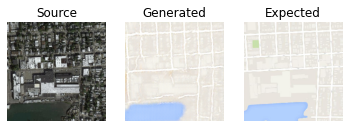

In [55]:
[X1, X2] = dataset
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)

In [31]:
from tensorflow.keras.models import load_model
model = load_model('model_010960.h5')

In [45]:
from skimage.io import imread, imshow

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


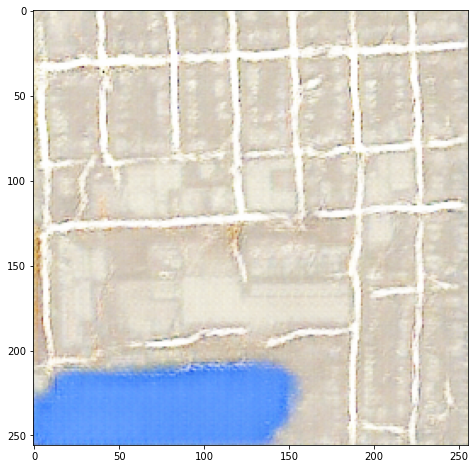

In [56]:
plt.figure(figsize=(8,8))
plt.imshow(gen_image[0])
plt.show()

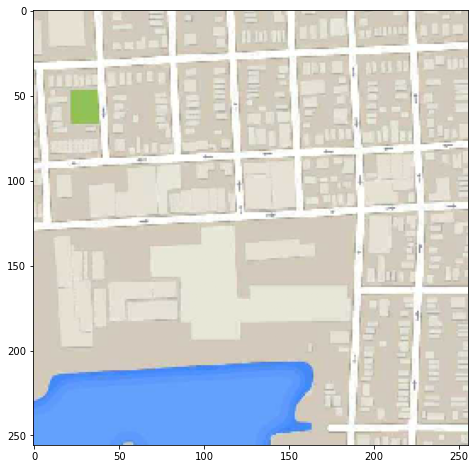

In [57]:
plt.figure(figsize=(8,8))
plt.imshow(tar_image[0])
plt.show()